In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [29]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),       
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),   
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [30]:
def potential(x,k,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    
    poten=-10/x+x
    return poten

In [31]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:9" if torch.cuda.is_available() else "cpu")

La=0
Lb =50
L=Lb-La  # domain length
N = 1000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)

# 控制势函数的大小
l_max=1
scale=10

en_num=30
extend_num=10
epoch=200000
lr=0.01

diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

In [32]:
real_en_list=[]
for l in range(l_max):
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid,b_lap,scale)+centrifugal_poten
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    real_en=eigenvalues[:en_num].detach()
    real_en_list.append(real_en)

In [33]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=80,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    
    loss=0
    for l in range(l_max):
        centrifugal_poten=-b_lap*(l+1)*l/grid**2
        V_diag=model(grid)+centrifugal_poten
        A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
        eigenvalues= torch.linalg.eigvalsh(A)
        output=eigenvalues[:en_num]
        
        loss+=loss_fn(output,real_en_list[l])
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:11.69921875,time:0.017565250396728516,lr:0.01
epoch:10,loss:6.621110916137695,time:0.14377689361572266,lr:0.01
epoch:20,loss:3.3999457359313965,time:0.2572612762451172,lr:0.01
epoch:30,loss:1.2146135568618774,time:0.3695640563964844,lr:0.01
epoch:40,loss:1.4498013257980347,time:0.484546422958374,lr:0.01
epoch:50,loss:1.951440691947937,time:0.5975661277770996,lr:0.01
epoch:60,loss:0.6076349020004272,time:0.7097439765930176,lr:0.01
epoch:70,loss:1.3110934495925903,time:0.8229303359985352,lr:0.01
epoch:80,loss:1.4419366121292114,time:0.936896800994873,lr:0.01
epoch:90,loss:0.6900877952575684,time:1.0491595268249512,lr:0.01
epoch:100,loss:1.6496549844741821,time:1.1654832363128662,lr:0.01
epoch:110,loss:1.385189175605774,time:1.277681589126587,lr:0.01
epoch:120,loss:1.1985819339752197,time:1.390883207321167,lr:0.01
epoch:130,loss:1.8323394060134888,time:1.5031733512878418,lr:0.01
epoch:140,loss:2.002108573913574,time:1.6162798404693604,lr:0.01
epoch:150,loss:1.4648507833480835

In [34]:
# -1.5237e-01, -1.3085e-01, -1.2296e-01, -1.0179e-01, -7.9435e-02,
#         -5.6185e-02, -3.5326e-02, -1.0974e-02,  1.4396e-02,  4.2974e-02
# -1.2695e-01, -9.2922e-02, -5.8262e-02, -2.2549e-02,  1.4835e-02,
#          5.1943e-02,  9.0080e-02,  1.2834e-01,  1.6763e-01,  2.0718e-01

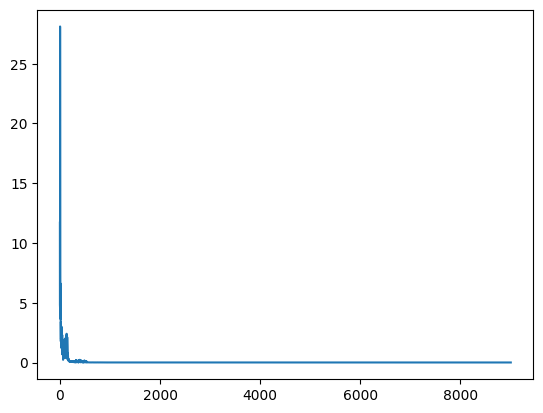

In [35]:
plt.plot(loss_list)
plt.show()

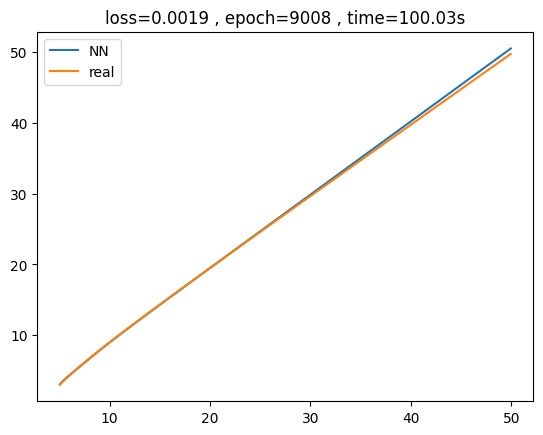

In [36]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[100:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()


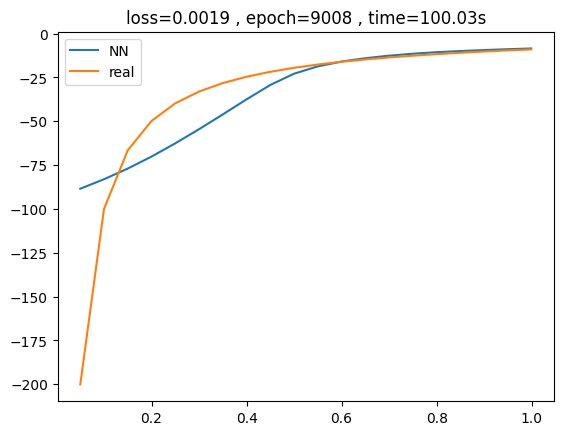

In [37]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[:20]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

In [38]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num]

real_en=real_en_list[0]
error=output-real_en
rela_error=error/real_en
print('final error:',error)
print('relative error:',rela_error)

final error: tensor([ 0.0000e+00, -6.1035e-05, -4.1008e-05, -1.4424e-05, -2.3365e-05,
        -2.5198e-03,  9.0828e-03,  1.6931e-02,  9.5367e-07, -1.5655e-03,
        -4.9114e-05, -2.8610e-06,  1.8501e-04,  5.3692e-04,  5.9891e-04,
         4.1866e-04,  1.2779e-04, -1.8120e-04, -6.3705e-04, -1.2712e-03,
        -1.8435e-03, -2.2039e-03, -2.1467e-03, -1.7281e-03, -9.8610e-04,
        -7.6294e-06,  1.2035e-03,  2.6627e-03,  4.3926e-03,  6.3896e-03],
       device='cuda:9', grad_fn=<SubBackward0>)
relative error: tensor([-0.0000e+00,  5.2117e-06,  9.7171e-06,  1.5116e-05, -2.1423e-05,
        -9.5786e-04,  2.3250e-03,  3.3719e-03,  1.5826e-07, -2.2519e-04,
        -6.2837e-06, -3.3144e-07,  1.9665e-05,  5.2892e-05,  5.5119e-05,
         3.6231e-05,  1.0455e-05, -1.4077e-05, -4.7177e-05, -9.0036e-05,
        -1.2523e-04, -1.4396e-04, -1.3513e-04, -1.0504e-04, -5.7982e-05,
        -4.3466e-07,  6.6532e-05,  1.4302e-04,  2.2952e-04,  3.2515e-04],
       device='cuda:9', grad_fn=<DivBackward0

energy level while l=0


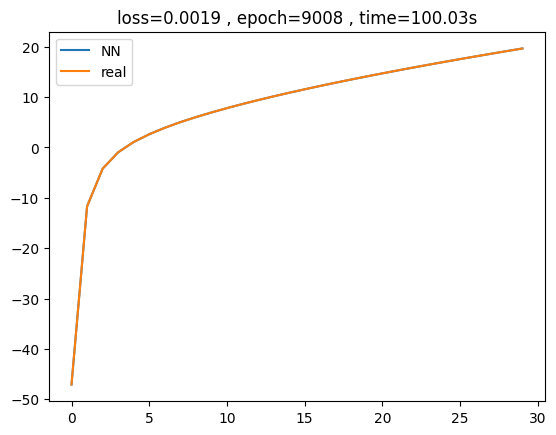

In [39]:
print('energy level while l=0')
plt.plot(output[:].detach().cpu().numpy(),label='NN')
plt.plot(real_en[:].detach().cpu().numpy(),label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

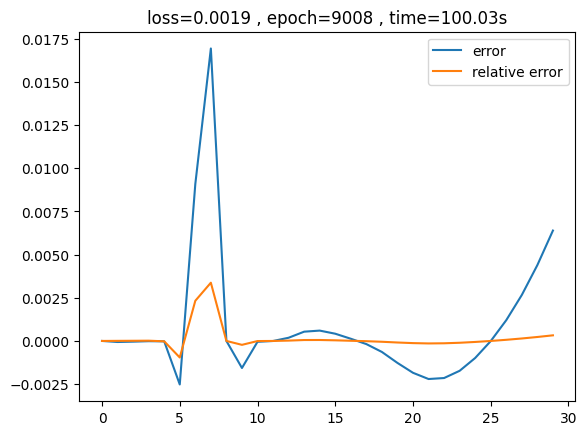

In [40]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(rela_error.detach().cpu().numpy(),label='relative error')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()